# Initialize

In [2]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [3]:
import sys
import astra
import numpy as np
import scipy.io

import tigre

sys.path.insert(0,'../xpecgen')

import xpecgen as xg

In [3]:
class IndexTracker(object):
    def __init__(self, ax, X):
        self.ax = ax
        ax.set_title('Geometry Viewer')

        self.X = X
        rows, cols, self.slices = X.shape
        self.ind = self.slices//2
        
        ss = rows*8/512

        self.im = ax.imshow(self.X[:, :, self.ind],cmap='bone',aspect='equal',extent=[-ss,ss,-ss,ss])
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[:, :, self.ind])
        self.ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()

# run

<IPython.core.display.Javascript object>


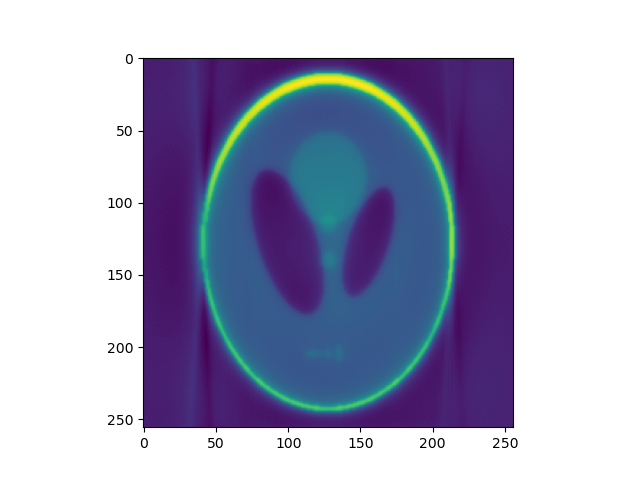

In [89]:
vol_geom = astra.create_vol_geom(256, 256)

ratio = 256/160

proj_geom = astra.create_proj_geom('fanflat', ratio*0.784, 512, np.linspace(0,np.pi,180,False),ratio*1000,ratio*520)
proj_id = astra.create_projector('strip_fanflat', proj_geom, vol_geom)
P = 0.1*scipy.io.loadmat('/home/xcite/astra-toolbox/samples/python/phantom.mat')['phantom256']

sinogram_id, sinogram = astra.create_sino(P, proj_id)

# Create a data object for the reconstruction
rec_id = astra.data2d.create('-vol', vol_geom)

cfg = astra.astra_dict('CGLS')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ProjectorId'] = proj_id
alg_id = astra.algorithm.create(cfg)
astra.algorithm.run(alg_id, 5)
rec = astra.data2d.get(rec_id)
pylab.figure()
pylab.imshow(rec)
pylab.show()
astra.algorithm.delete(alg_id)
astra.data2d.delete(rec_id)
astra.data2d.delete(sinogram_id)
astra.projector.delete(proj_id)

In [93]:
phantom = xg.Catphan_515()

ny = 64

angles = np.linspace(pi/2,3/2*pi,180,False)
phan = np.tile(P,[ny,1,1]).astype(np.float32)

phantom.geomet.nVoxel = np.array(phan.shape)
phantom.geomet.DSD = 1520
phantom.geomet.sVoxel = np.array([ny/256*160, 160, 160])
phantom.geomet.dVoxel = phantom.geomet.sVoxel/phantom.geomet.nVoxel 
phantom.geomet.dDetector = np.array([0.784, 0.784])
phantom.geomet.nDetector = np.array([ny, 512])
phantom.geomet.sDetector = phantom.geomet.dDetector * phantom.geomet.nDetector  
phantom.geomet.accuracy = 20

projs = tigre.Ax(np.tile(np.fliplr(P),[ny,1,1]).astype(np.float32),phantom.geomet,angles)

In [94]:
print(phantom.geomet)

TIGRE parameters
-----
Geometry parameters
Distance from source to detector (DSD) = 1520 mm
Distance from source to origin (DSO)= 1000 mm
-----
Detector parameters
Number of pixels (nDetector) = [ 64 512]
Size of each pixel (dDetector) = [0.784 0.784] mm
Total size of the detector (sDetector) = [ 50.176 401.408] mm
-----
Image parameters
Number of voxels (nVoxel) = [ 64 256 256]
Total size of the image (sVoxel) = [ 40. 160. 160.] mm
Size of each voxel (dVoxel) = [0.625 0.625 0.625] mm
-----
Offset correction parameters
Offset of image from origin (offOrigin) = [0 0 0] mm
Offset of detector (offDetector) = [0 0] mm
-----
Auxillary parameters
Samples per pixel of forward projection (accuracy) = 20
-----
Rotation of the Detector (rotDetector) = [0 0 0] rad


In [95]:
projs.transpose([0,2,1]).shape

(180, 512, 64)

<IPython.core.display.Javascript object>


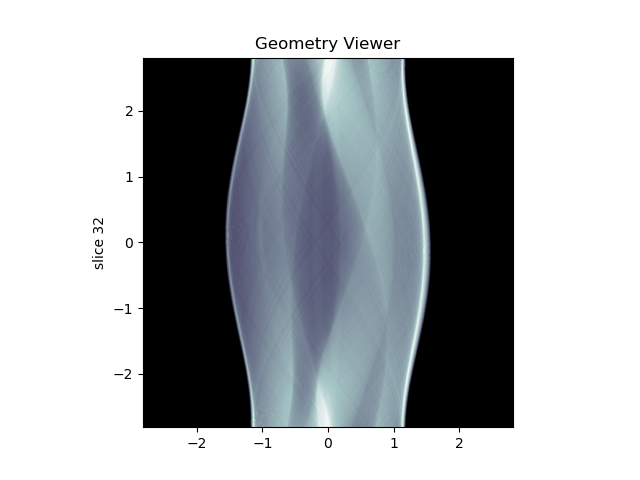

9

In [96]:
fig = plt.figure()

ax1 = fig.add_subplot(111)

tracker1 = IndexTracker(ax1, projs.transpose([0,2,1]))


fig.canvas.mpl_connect('scroll_event', tracker1.onscroll)

<IPython.core.display.Javascript object>


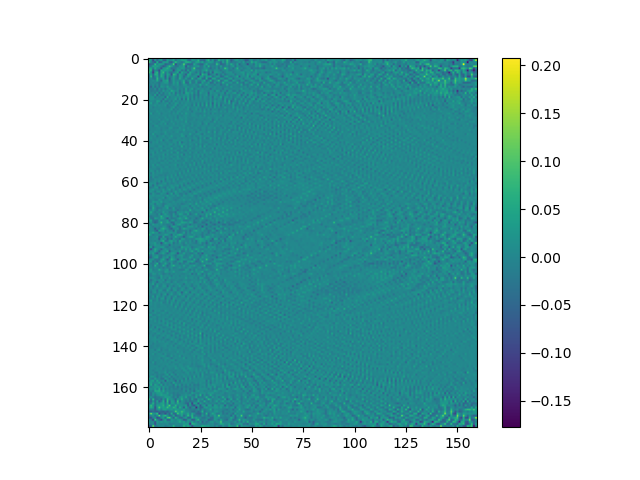

In [97]:
plt.figure();plt.imshow(1.601*projs.transpose([0,2,1])[:,180:340,30] - sinogram[:,180:340]);plt.colorbar()

<IPython.core.display.Javascript object>


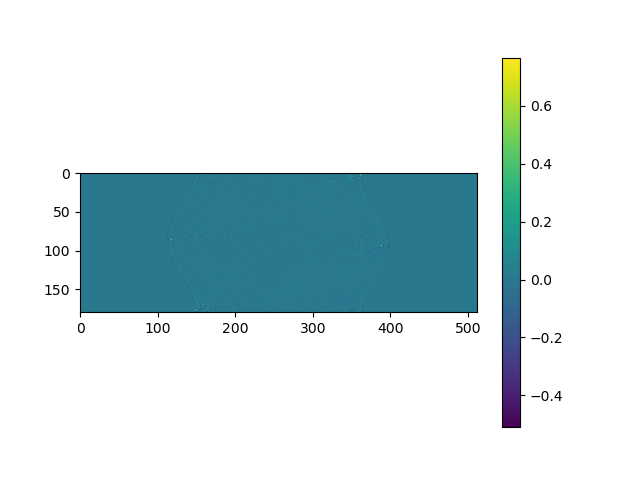

In [98]:
plt.figure();plt.imshow(1.601*projs.transpose([0,2,1])[:,:,30] - sinogram[:,:]);plt.colorbar()

<IPython.core.display.Javascript object>


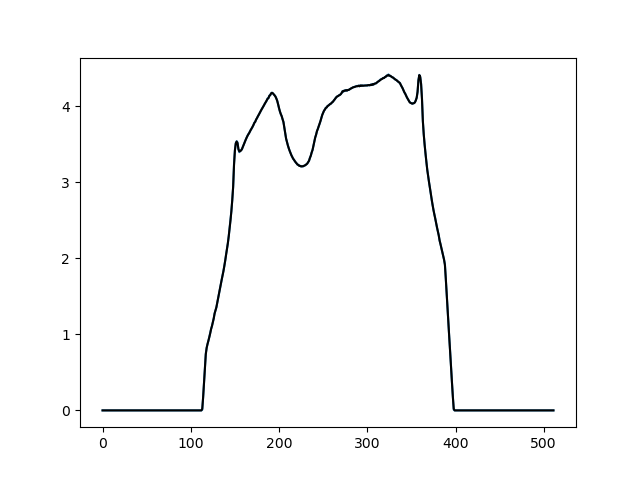

In [99]:
plt.figure()
plt.plot(1.6*np.mean(projs.transpose([0,2,1])[:,:,5],0))
plt.plot(np.mean(sinogram,0),'k')

<IPython.core.display.Javascript object>


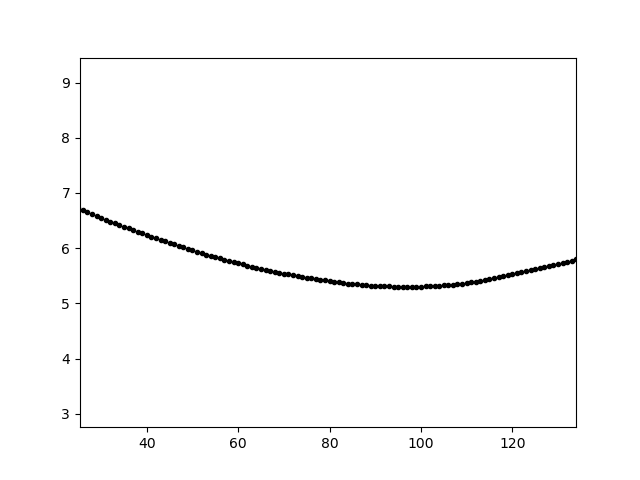

In [88]:
figure()

for ii in range(1000):
    plt.plot(ii,np.sum(np.abs((1.599 + ii/100000)*np.mean(projs.transpose([0,2,1])[:,:,10],0) - np.mean(sinogram,0))),'k.')

<IPython.core.display.Javascript object>


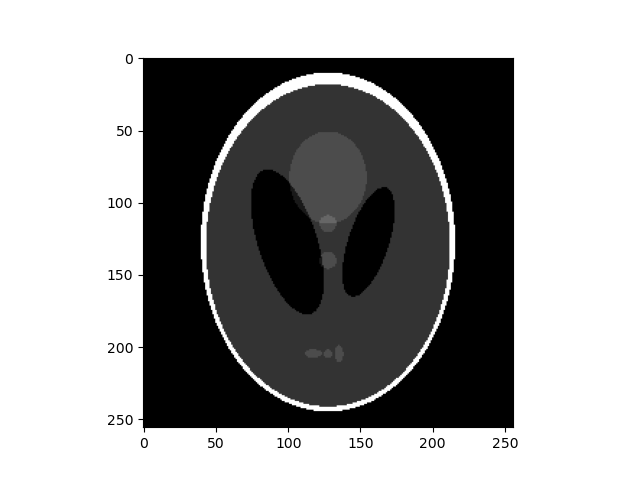

<IPython.core.display.Javascript object>


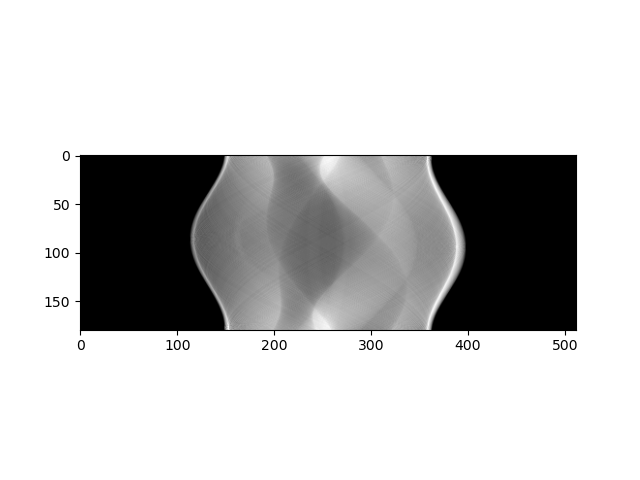

In [8]:
import astra
import numpy as np

vol_geom = astra.create_vol_geom(256, 256)

ratio = 256/160

proj_geom = astra.create_proj_geom('fanflat', ratio*0.784, 512, np.linspace(0,np.pi,180,False),ratio*1000,ratio*520)

# For CPU-based algorithms, a "projector" object specifies the projection
# model used. In this case, we use the "strip" model.
proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)

# Create a sinogram from a phantom
import scipy.io
P = scipy.io.loadmat('/home/xcite/astra-toolbox/samples/python/phantom.mat')['phantom256']
sinogram_id, sinogram = astra.create_sino(P, proj_id)

plt.gray()
plt.figure()
plt.imshow(P)
plt.figure()
plt.imshow(sinogram)

# run from fastcat

In [147]:
phantom = xg.Catphan_515()

ny = 10

spectrum_file = 'Al_spectrum_25'

det = 'CuGOS-784-micrometer'

# angles = np.linspace(0,2*pi,180)

phantom = xg.Catphan_515()

s = xg.Spectrum()

s.load(spectrum_file)

kernel = xg.Kernel(s, det)

angles = np.linspace(pi/2,3/2*pi,180,False)

phantom.geomet.DSD = 1520
phantom.geomet.sVoxel = np.array([ny*160/512, 160, 160])
phantom.geomet.dVoxel = phantom.geomet.sVoxel/phantom.geomet.nVoxel 
phantom.geomet.dDetector = np.array([0.784, 0.784])
phantom.geomet.nDetector = np.array([ny, 512])
phantom.geomet.sDetector = phantom.geomet.dDetector * phantom.geomet.nDetector  
phantom.geomet.accuracy = 20

# Don't want to look for zeros
useful_phantom = phantom.phantom != 0
# These are what I used in the Monte Carlo
original_energies_keV = np.array([30, 40, 50 ,60, 70, 80 ,90 ,100 ,300 ,500 ,700, 900, 1000 ,2000 ,4000 ,6000])
# Loading the file from the monte carlo
deposition = np.load(kernel.deposition_efficiency_file,allow_pickle=True)
# This is a scaling factor that I found to work to convert energy deposition to photon probability eta
deposition_summed = deposition[0]/(original_energies_keV/1000)/1000000
# The index of the different materials
masks = np.zeros([len(phantom.phan_map)-1,useful_phantom.shape[0],useful_phantom.shape[1],useful_phantom.shape[2]])
mapping_functions = []
# Get the mapping functions for the different tissues to reconstruct the phantom by energy
for ii in range(1,len(phantom.phan_map)):       
    mapping_functions.append(xg.get_mu(phantom.phan_map[ii].split(':')[0]))
    masks[ii-1] = phantom.phantom == ii
phantom2 = phantom.phantom.copy().astype(np.float32)

for ii in range(0,len(phantom.phan_map)-1):
    phantom2[masks[ii].astype(bool)] = mapping_functions[ii](100)

projs = tigre.Ax(phantom2,phantom.geomet,angles)

<IPython.core.display.Javascript object>


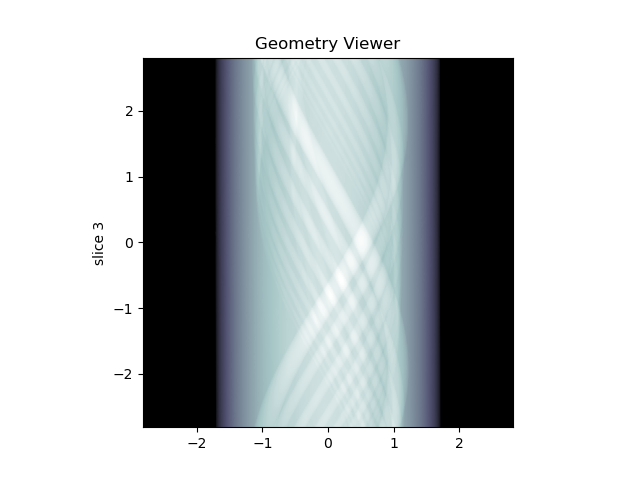

9

In [148]:
fig = plt.figure()

ax1 = fig.add_subplot(111)

tracker1 = IndexTracker(ax1, projs.transpose([0,2,1]))


fig.canvas.mpl_connect('scroll_event', tracker1.onscroll)

<IPython.core.display.Javascript object>


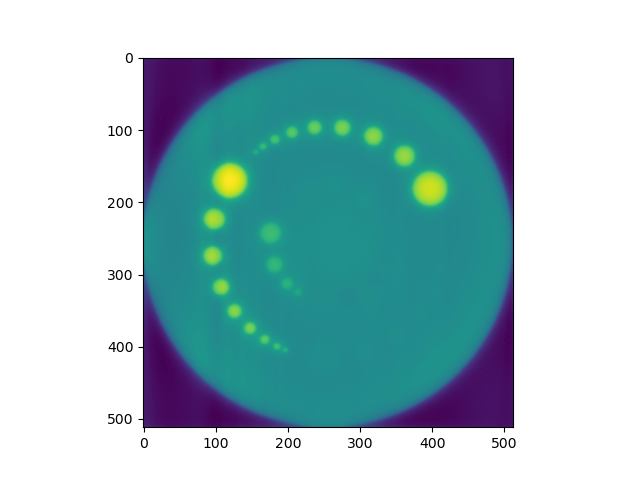

In [185]:
vol_geom = astra.create_vol_geom(512, 512)

ratio = 512/160

proj_geom = astra.create_proj_geom('fanflat', ratio*0.784, 512, angles - np.pi/2,ratio*1000,ratio*520)
proj_id = astra.create_projector('strip_fanflat', proj_geom, vol_geom)

sinogram_id, sinogram = astra.create_sino(np.fliplr(phantom2[0,:,:]), proj_id)

# Create a data object for the reconstruction
rec_id = astra.data2d.create('-vol', vol_geom)

cfg = astra.astra_dict('CGLS')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ProjectorId'] = proj_id

alg_id = astra.algorithm.create(cfg)
astra.algorithm.run(alg_id, 5)
rec = astra.data2d.get(rec_id)
pylab.figure()
pylab.imshow(rec)
pylab.show()
# astra.algorithm.delete(alg_id)
# astra.data2d.delete(rec_id)
# astra.data2d.delete(sinogram_id)
# astra.projector.delete(proj_id)

In [4]:
# rec_id = astra.data2d.create('-vol', vol_geom)

# astra.data2d.store(sin_id,projs[0,:,:]*(1.6*2))

cfg = astra.astra_dict('CGLS')

cfg['ReconstructionDataId'] = 96
cfg['ProjectionDataId'] =  88
cfg['ProjectorId'] =  86

alg_id = astra.algorithm.create(cfg)


Exception: Unable to initialize Algorithm.

In [194]:
print(rec_id,sinogram_id,proj_id)

96 88 86


In [191]:
vol_geom

{'option': {'WindowMinX': -256.0,
  'WindowMaxX': 256.0,
  'WindowMinY': -256.0,
  'WindowMaxY': 256.0},
 'GridRowCount': 512,
 'GridColCount': 512}

<IPython.core.display.Javascript object>


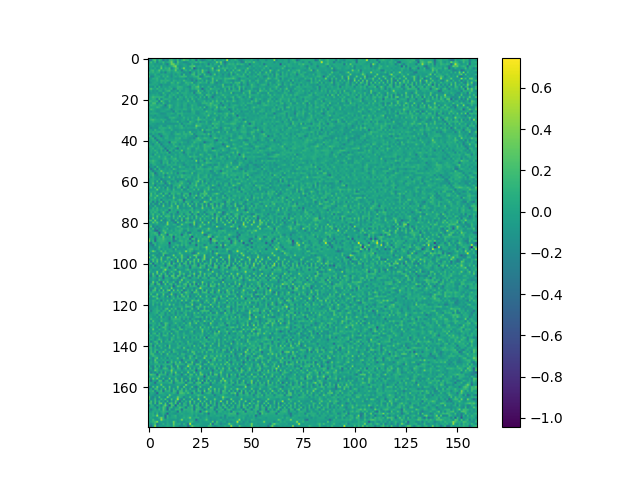

In [170]:
plt.figure();plt.imshow(1.6*2*projs.transpose([0,2,1])[:,180:340,5] - sinogram[:,180:340]);plt.colorbar()

<IPython.core.display.Javascript object>


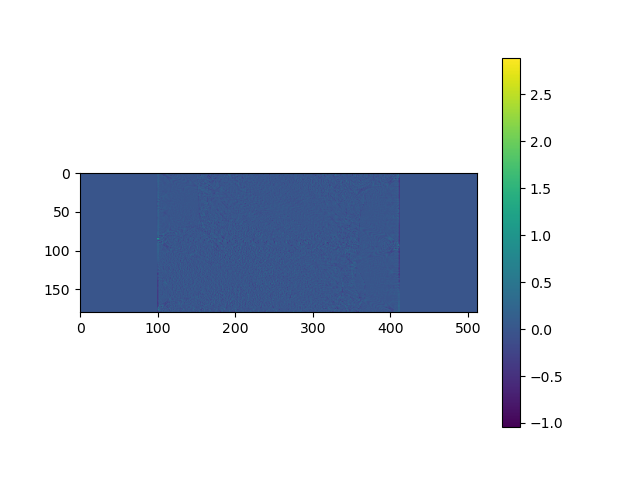

In [171]:
plt.figure();plt.imshow(1.6*2*projs.transpose([0,2,1])[:,:,5] - sinogram[:,:]);plt.colorbar()

<IPython.core.display.Javascript object>


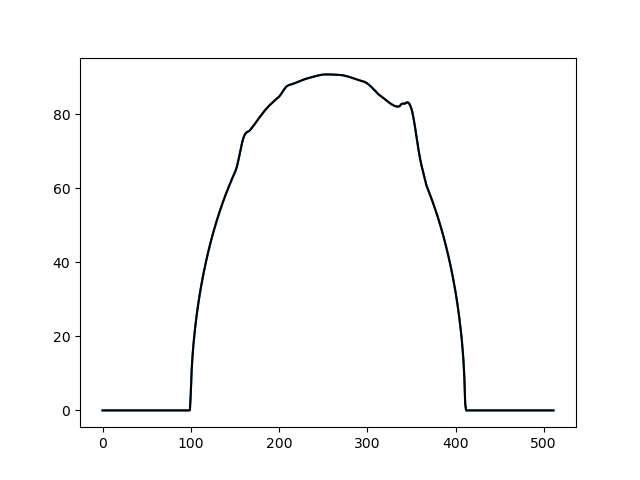

In [152]:
plt.figure()
plt.plot(1.6*2*np.mean(projs.transpose([0,2,1])[:,:,5],0))
plt.plot(np.mean(sinogram,0),'k')

In [9]:
phantom = xg.Catphan_515()

angles = np.linspace(0,pi,180,False)

# phan = np.tile(P,[10,1,1]).astype(np.float32)

# phantom.geomet.nVoxel = np.array(phan.shape)
phantom.geomet.DSD = 1520
phantom.geomet.dVoxel = phantom.geomet.sVoxel/phantom.geomet.nVoxel 
phantom.geomet.dDetector = np.array([0.784, 0.784])
phantom.geomet.sDetector = phantom.geomet.dDetector * phantom.geomet.nDetector  
phantom.geomet.accuracy = 0.5

In [39]:
def tigre2astra_initialize(phantom,geomet,angles,tile=False):
    
    import astra
    
    tigre_shape = geomet.nVoxel
    
    # Create a geometry object
    vol_geom = astra.create_vol_geom(tigre_shape[1],tigre_shape[2])
    # Create the ratio of 1mm to 1 voxel
    ratio = tigre_shape[1]/geomet.sVoxel[0]
    # create the projection
    proj_geom = astra.create_proj_geom('fanflat', ratio*geomet.dDetector[0],
                                       geomet.nDetector[1], angles + np.pi/2,
                                       ratio*geomet.DSO,ratio*(geomet.DSD-geomet.DSO))
    # For CPU-based algorithms, a "projector" object specifies the projection
    # model used. In this case, we use the "strip" model.
    proj_id = astra.create_projector('strip_fanflat', proj_geom, vol_geom)
    
    if tile:
        sin_id, sinogram = astra.create_sino(phantom[0,:,:], proj_id)
        
        return 1.601*np.tile(sinogram,[tigre_shape[0],1,1]),sin_id, proj_id, vol_geom
    else:
        sinogram = np.zeros([tigre_shape[0],len(angles),geomet.nDetector[1]])
        
        sin_id = None
        
        for ii in range(tigre_shape[0]):
            
            if sin_id is not None:
                astra.data2d.delete(sin_id)
                
            sin_id, sinogram[ii,:,:] = astra.create_sino(phantom[ii,:,:], proj_id) # this is some sort of relation
            
        return 1.601*sinogram, sin_id, proj_id, vol_geom

In [18]:
# def tigre2astra(phantom,geomet,angles,tile=False):

geomet = phantom.geomet
import astra

tigre_shape = geomet.nVoxel

# Create a geometry object
vol_geom = astra.create_vol_geom(tigre_shape[1],tigre_shape[2])
# Create the ratio of 1mm to 1 voxel
ratio = tigre_shape[1]/geomet.sVoxel[0]
# create the projection
proj_geom = astra.create_proj_geom('fanflat', ratio*geomet.dDetector[0],
                                   geomet.nDetector[1], angles + np.pi/2,
                                   ratio*geomet.DSO,ratio*(geomet.DSD-geomet.DSO))
# For CPU-based algorithms, a "projector" object specifies the projection
# model used. In this case, we use the "strip" model.
proj_id = astra.create_projector('strip_fanflat', proj_geom, vol_geom)

# if tile:
#     sin_id, sinogram = astra.create_sino(phantom[0,:,:], proj_id)

#     return np.tile(sinogram,[tigre_shape[0],1,1]),sin_id, proj_id, vol_geom
# else:
sinogram = np.zeros([tigre_shape[0],len(angles),geomet.nDetector[1]])

sin_id = None

for ii in range(tigre_shape[0]):

    if sin_id is not None:
        astra.data2d.delete(sin_id)

    sin_id, sinogram[ii,:,:] = astra.create_sino(phantom.phantom[ii,:,:], proj_id) # this is some sort of relation
            
#         return sinogram, sin_id, proj_id, vol_geom

In [11]:
clear sin_id

In [12]:
projs, sin_id, proj_id, vol_geom = tigre2astra(phantom.phantom,phantom.geomet,angles,tile=False)

In [32]:
def astra_recon(projs, sin_id, proj_id, vol_geom,algo ='CGLS',niter=10):
    
    rec_id = astra.data2d.create('-vol', vol_geom)

    cfg = astra.astra_dict(algo)
    
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sin_id
    cfg['ProjectorId'] = proj_id
    
    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)

    for ii in range(projs.T.shape[2]):

        astra.data2d.store(sin_id,projs[ii,:,:]/1.601)
        # Available algorithms:
        # ART, SART, SIRT, CGLS, FBP

        # Run 20 iterations of the algorithm
        # This will have a runtime in the order of 10 seconds.
        astra.algorithm.run(alg_id,niter)

        # Get the result
        rec = astra.data2d.get(rec_id)

        recon.append(rec)
        
    return np.array(recon)

In [83]:
projs, sin_id, proj_id, vol_geom = tigre2astra(phantom.phantom,phantom.geomet,angles,tile=True)

In [33]:
recon = astra_recon(projs, sin_id, proj_id, vol_geom)

<IPython.core.display.Javascript object>


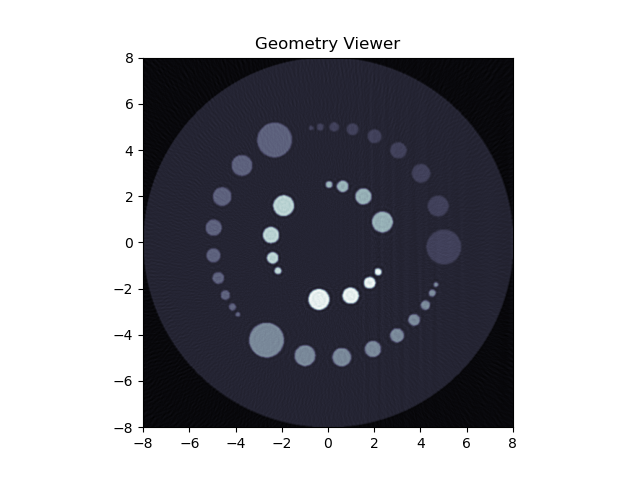

9

In [38]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

tracker1 = IndexTracker(ax1, recon.T)#transpose([0,2,1]))
fig.canvas.mpl_connect('scroll_event', tracker1.onscroll)

In [87]:
projs.shape

(10, 180, 512)

In [89]:
sin_id

255

In [22]:
# Create a data object for the reconstruction
rec_id = astra.data2d.create('-vol', vol_geom)

recon = []
# Set up the parameters for a reconstruction algorithm using the CPU
# The main difference with the configuration of a GPU algorithm is the
# extra ProjectorId setting.
cfg = astra.astra_dict('CGLS')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ProjectorId'] = proj_id
# cfg['option'] = { 'ShortScan': True }

# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

for ii in range(projs.T.shape[2]):

    astra.data2d.store(sinogram_id,projs[ii,:,:])
    # Available algorithms:
    # ART, SART, SIRT, CGLS, FBP

    # Run 20 iterations of the algorithm
    # This will have a runtime in the order of 10 seconds.
    astra.algorithm.run(alg_id,10)

    # Get the result
    rec = astra.data2d.get(rec_id)
    
    recon.append(rec)
    
pylab.figure()
pylab.imshow(rec)
pylab.show()

Exception: Unable to initialize Algorithm.

<IPython.core.display.Javascript object>


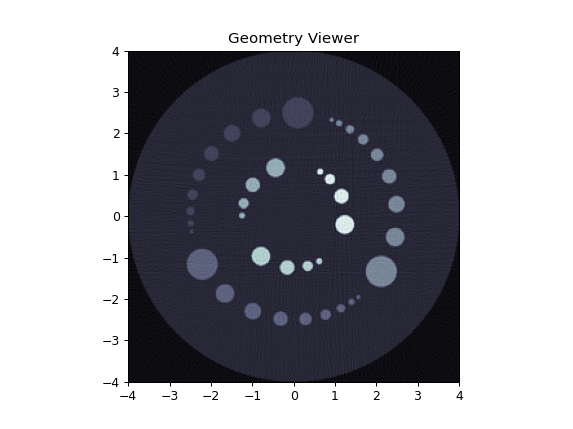

9

In [56]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

tracker1 = IndexTracker(ax1, np.array(recon).T)#transpose([0,2,1]))
fig.canvas.mpl_connect('scroll_event', tracker1.onscroll)

In [34]:
# Clean up.
astra.algorithm.delete(alg_id)

In [22]:
astra.data2d.delete(rec_id)
astra.data2d.delete(sinogram_id)
astra.projector.delete(proj_id)

Exception: Unable to initialize Algorithm.

In [110]:
print(phantom.geomet)

TIGRE parameters
-----
Geometry parameters
Distance from source to detector (DSD) = 1520 mm
Distance from source to origin (DSO)= 1000 mm
-----
Detector parameters
Number of pixels (nDetector) = [ 64 512]
Size of each pixel (dDetector) = [0.784 0.784] mm
Total size of the detector (sDetector) = [ 50.176 401.408] mm
-----
Image parameters
Number of voxels (nVoxel) = [ 10 256 256]
Total size of the image (sVoxel) = [160 160 160] mm
Size of each voxel (dVoxel) = [16.     0.625  0.625] mm
-----
Offset correction parameters
Offset of image from origin (offOrigin) = [0 0 0] mm
Offset of detector (offDetector) = [0 0] mm
-----
Auxillary parameters
Samples per pixel of forward projection (accuracy) = 0.5
-----
Rotation of the Detector (rotDetector) = [0 0 0] rad


<IPython.core.display.Javascript object>


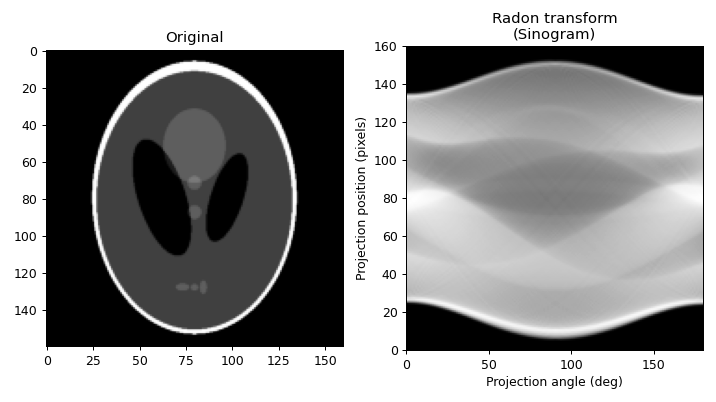

/home/xcite/anaconda3/lib/python3.7/site-packages/skimage/transform/radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])


In [43]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale

image = shepp_logan_phantom()
image = rescale(image, scale=0.4, mode='reflect', multichannel=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta, circle=True)
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')

fig.tight_layout()
plt.show()

FBP rms reconstruction error: 0.0283


<IPython.core.display.Javascript object>


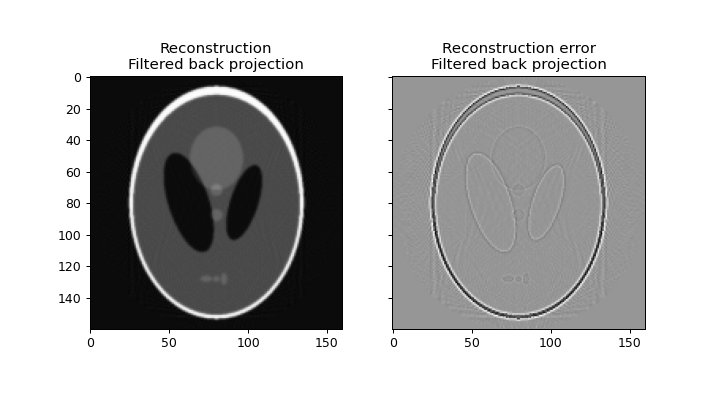

In [57]:
# from skimage.transform import iradon

reconstruction_fbp = iradon(sinogram, theta=theta, circle=True)
error = reconstruction_fbp - image
print(f"FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}")

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5),
                               sharex=True, sharey=True)
ax1.set_title("Reconstruction\nFiltered back projection")
ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nFiltered back projection")
ax2.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()

In [56]:
fftmodule = np.fft
from functools import partial

if fftmodule is np.fft:
    # fallback from scipy.fft to scipy.fftpack instead of numpy.fft
    # (fftpack preserves single precision while numpy.fft does not)
    from scipy.fftpack import fft, ifft

def iradon(radon_image, theta=None, output_size=None,
           filter_name="ramp", interpolation="linear", circle=True):
    """Inverse radon transform.
    Reconstruct an image from the radon transform, using the filtered
    back projection algorithm.
    Parameters
    ----------
    radon_image : array_like, dtype=float
        Image containing radon transform (sinogram). Each column of
        the image corresponds to a projection along a different
        angle. The tomography rotation axis should lie at the pixel
        index ``radon_image.shape[0] // 2`` along the 0th dimension of
        ``radon_image``.
    theta : array_like, dtype=float, optional
        Reconstruction angles (in degrees). Default: m angles evenly spaced
        between 0 and 180 (if the shape of `radon_image` is (N, M)).
    output_size : int, optional
        Number of rows and columns in the reconstruction.
    filter_name : str, optional
        Filter used in frequency domain filtering. Ramp filter used by default.
        Filters available: ramp, shepp-logan, cosine, hamming, hann.
        Assign None to use no filter.
    interpolation : str, optional
        Interpolation method used in reconstruction. Methods available:
        'linear', 'nearest', and 'cubic' ('cubic' is slow).
    circle : boolean, optional
        Assume the reconstructed image is zero outside the inscribed circle.
        Also changes the default output_size to match the behaviour of
        ``radon`` called with ``circle=True``.
    Returns
    -------
    reconstructed : ndarray
        Reconstructed image. The rotation axis will be located in the pixel
        with indices
        ``(reconstructed.shape[0] // 2, reconstructed.shape[1] // 2)``.
    .. versionchanged :: 0.19
        In ``iradon``, ``filter`` argument is deprecated in favor of
        ``filter_name``.
    References
    ----------
    .. [1] AC Kak, M Slaney, "Principles of Computerized Tomographic
           Imaging", IEEE Press 1988.
    .. [2] B.R. Ramesh, N. Srinivasa, K. Rajgopal, "An Algorithm for Computing
           the Discrete Radon Transform With Some Applications", Proceedings of
           the Fourth IEEE Region 10 International Conference, TENCON '89, 1989
    Notes
    -----
    It applies the Fourier slice theorem to reconstruct an image by
    multiplying the frequency domain of the filter with the FFT of the
    projection data. This algorithm is called filtered back projection.
    """
    if radon_image.ndim != 2:
        raise ValueError('The input image must be 2-D')

    if theta is None:
        theta = np.linspace(0, 180, radon_image.shape[1], endpoint=False)

    angles_count = len(theta)
    if angles_count != radon_image.shape[1]:
        raise ValueError("The given ``theta`` does not match the number of "
                         "projections in ``radon_image``.")

    interpolation_types = ('linear', 'nearest', 'cubic')
    if interpolation not in interpolation_types:
        raise ValueError("Unknown interpolation: %s" % interpolation)

    filter_types = ('ramp', 'shepp-logan', 'cosine', 'hamming', 'hann', None)
    if filter_name not in filter_types:
        raise ValueError("Unknown filter: %s" % filter_name)

    img_shape = radon_image.shape[0]
    if output_size is None:
        # If output size not specified, estimate from input radon image
        if circle:
            output_size = img_shape
        else:
            output_size = int(np.floor(np.sqrt((img_shape) ** 2 / 2.0)))

    if circle:
        radon_image = _sinogram_circle_to_square(radon_image)
        img_shape = radon_image.shape[0]

    # Resize image to next power of two (but no less than 64) for
    # Fourier analysis; speeds up Fourier and lessens artifacts
    projection_size_padded = max(64, int(2 ** np.ceil(np.log2(2 * img_shape))))
    pad_width = ((0, projection_size_padded - img_shape), (0, 0))
    img = np.pad(radon_image, pad_width, mode='constant', constant_values=0)

    # Apply filter in Fourier domain
    fourier_filter = _get_fourier_filter(projection_size_padded, filter_name)
    projection = fft(img, axis=0) * fourier_filter
    radon_filtered = np.real(ifft(projection, axis=0)[:img_shape, :])

    # Reconstruct image by interpolation
    reconstructed = np.zeros((output_size, output_size))
    radius = output_size // 2
    xpr, ypr = np.mgrid[:output_size, :output_size] - radius
    x = np.arange(img_shape) - img_shape // 2

    for col, angle in zip(radon_filtered.T, np.deg2rad(theta)):
        t = ypr * np.cos(angle) - xpr * np.sin(angle)
        if interpolation == 'linear':
            interpolant = partial(np.interp, xp=x, fp=col, left=0, right=0)
        else:
            interpolant = interp1d(x, col, kind=interpolation,
                                   bounds_error=False, fill_value=0)
        reconstructed += interpolant(t)

    if circle:
        out_reconstruction_circle = (xpr ** 2 + ypr ** 2) > radius ** 2
        reconstructed[out_reconstruction_circle] = 0.

    return reconstructed * np.pi / (2 * angles_count)


def _sinogram_circle_to_square(sinogram):
    diagonal = int(np.ceil(np.sqrt(2) * sinogram.shape[0]))
    pad = diagonal - sinogram.shape[0]
    old_center = sinogram.shape[0] // 2
    new_center = diagonal // 2
    pad_before = new_center - old_center
    pad_width = ((pad_before, pad - pad_before), (0, 0))
    return np.pad(sinogram, pad_width, mode='constant', constant_values=0)

def _get_fourier_filter(size, filter_name):
    """Construct the Fourier filter.
    This computation lessens artifacts and removes a small bias as
    explained in [1], Chap 3. Equation 61.
    Parameters
    ----------
    size: int
        filter size. Must be even.
    filter_name: str
        Filter used in frequency domain filtering. Filters available:
        ramp, shepp-logan, cosine, hamming, hann. Assign None to use
        no filter.
    Returns
    -------
    fourier_filter: ndarray
        The computed Fourier filter.
    References
    ----------
    .. [1] AC Kak, M Slaney, "Principles of Computerized Tomographic
           Imaging", IEEE Press 1988.
    """
    n = np.concatenate((np.arange(1, size / 2 + 1, 2, dtype=np.int),
                        np.arange(size / 2 - 1, 0, -2, dtype=np.int)))
    f = np.zeros(size)
    f[0] = 0.25
    f[1::2] = -1 / (np.pi * n) ** 2

    # Computing the ramp filter from the fourier transform of its
    # frequency domain representation lessens artifacts and removes a
    # small bias as explained in [1], Chap 3. Equation 61
    fourier_filter = 2 * np.real(fft(f))         # ramp filter
    if filter_name == "ramp":
        pass
    elif filter_name == "shepp-logan":
        # Start from first element to avoid divide by zero
        omega = np.pi * fftmodule.fftfreq(size)[1:]
        fourier_filter[1:] *= np.sin(omega) / omega
    elif filter_name == "cosine":
        freq = np.linspace(0, np.pi, size, endpoint=False)
        cosine_filter = fftmodule.fftshift(np.sin(freq))
        fourier_filter *= cosine_filter
    elif filter_name == "hamming":
        fourier_filter *= fftmodule.fftshift(np.hamming(size))
    elif filter_name == "hann":
        fourier_filter *= fftmodule.fftshift(np.hanning(size))
    elif filter_name is None:
        fourier_filter[:] = 1

    return fourier_filter[:, np.newaxis]

In [ ]:
$IAEA_INDEX:
700 // VarianTrueBeam_6MV_01.IAEAphsp : IAEA website: http://www-nds.iaea.org/phsp/photon/

$TITLE:
Varian TrueBeam 6MV photon beam, cylindrical patient-independent phase space 

$FILE_TYPE:
0

$CHECKSUM:
1309442500

$RECORD_CONTENTS:
    1     // X is stored ?
    1     // Y is stored ?
    1     // Z is stored ?
    1     // U is stored ?
    1     // V is stored ?
    1     // W is stored ?
    0     // Weight is stored ?
    0     // Extra floats stored ?
    0     // Extra longs stored ?

$RECORD_CONSTANT:
     1.0000     // Constant Weight

$RECORD_LENGTH:
25

$BYTE_ORDER:
1234

$ORIG_HISTORIES:
1147392000

$PARTICLES:
52377701

$PHOTONS:
51767792

$ELECTRONS:
590071

$POSITRONS:
19838

$TRANSPORT_PARAMETERS:
Standard electromagnetic processes including G4UrbanMscModel2 for multiple scattering

$MONTE_CARLO_CODE_VERSION:
Geant4.9.2.p01

$MACHINE_TYPE:
LSF batch system with 1800 multi-core servers.

$GLOBAL_PHOTON_ENERGY_CUTOFF:
0.001207
$GLOBAL_PARTICLE_ENERGY_CUTOFF:
0.0001

$COORDINATE_SYSTEM_DESCRIPTION: 
Cartesian, right-handed:
The origin is inside the target bottom, x=y=0 is the central position of the target;
Positive x-axis is towards the linac, parallel to the upper jaws movement;
Positive z-axis is towards the water phantom or patient;

//  OPTIONAL INFORMATION

$BEAM_NAME: 
6MV photon beam stored on a cylindrical surface 

$FIELD_SIZE: 
Field-independent, phase space stored above the movable upper jaws.

$NOMINAL_SSD:
100 cm

$MC_INPUT_FILENAME:
Parmela input file with 71,712 particles provided by in-house simulations at Varian;

$VARIANCE_REDUCTION_TECHNIQUES:
NONE

$INITIAL_SOURCE_DESCRIPTION:
Parmela Phase Space with a FWHM for the x- and y-coordinates of 1 mm;
The FWHM for the x- and y-direction cosines are equal to 0.002;
The energy spectrum is non-Gaussian with a peak at 6.13 MeV and a tail extending up to 6.35 MeV.

$PUBLISHED_REFERENCE:
Phys. Med. Biol. 55, N211-N220 (2010)

$AUTHORS:
M. Constantin (1), D. Constantin (1), P.J. Keall (1), A. Narula (2), M. Svatos (2), and J. Perl (3)

$INSTITUTION:
(1) Dept. of Radiation Oncology, Radiation Physics Division, Stanford University, Stanford, CA 94304
(2) Varian Medical Systems, Inc., 3100 Hansen Way, Palo Alto, CA 94304
(3) SLAC National Accelerator Laboratory, Menlo Park, CA 94025

$LINK_VALIDATION:
http://iopscience.iop.org/0031-9155/55/8/N03

$ADDITIONAL_NOTES:
This is IAEA header as defined in the technical 
report IAEA(NDS)-0484, Vienna, 2006

$STATISTICAL_INFORMATION_PARTICLES:
//        Weight        Wmin       Wmax       <E>         Emin         Emax    Particle
      5.17678E+07          1          1      1.232      0.001207       6.308   PHOTONS
           590071          1          1     0.7586       1.3E-05       6.154   ELECTRONS
            19838          1          1      1.163       0.01163       4.704   POSITRONS

$STATISTICAL_INFORMATION_GEOMETRY:
 -30.3715  30.3717
 -30  30
 17.7671  27.3515

In [ ]:
$IAEA_INDEX:
1000   // Test header

$TITLE:
PHASESPACE in IAEA format 

$FILE_TYPE:
0

$CHECKSUM:
11865810 

$RECORD_CONTENTS:
    1     // X is stored ?
    1     // Y is stored ?
    0     // Z is stored ?
    1     // U is stored ?
    1     // V is stored ?
    1     // W is stored ?
    1     // Weight is stored ?
    1     // Extra floats stored ?
    1     // Extra longs stored ?
    3     // ZLAST variable stored in the extrafloat array [ 0] 
    2     // LATCH EGS variable stored in the extralong array [ 0] 

$RECORD_CONSTANT:
   100.0000     // Constant Z

$RECORD_LENGTH:
33

$BYTE_ORDER:
1234

$ORIG_HISTORIES:
1500000

$PARTICLES:
359570

$PHOTONS:
307933

$ELECTRONS:
51013

$POSITRONS:
624

$TRANSPORT_PARAMETERS:

$MACHINE_TYPE:

$MONTE_CARLO_CODE_VERSION:

$GLOBAL_PHOTON_ENERGY_CUTOFF:
  0.00000 
$GLOBAL_PARTICLE_ENERGY_CUTOFF:
  0.00000 
$COORDINATE_SYSTEM_DESCRIPTION:

//  OPTIONAL INFORMATION

$BEAM_NAME:

$FIELD_SIZE:

$NOMINAL_SSD:

$MC_INPUT_FILENAME:

$VARIANCE_REDUCTION_TECHNIQUES:

$INITIAL_SOURCE_DESCRIPTION:

$PUBLISHED_REFERENCE:

$AUTHORS:

$INSTITUTION:

$LINK_VALIDATION:

$ADDITIONAL_NOTES:
This is IAEA header as defined in the technical 
report IAEA(NDS)-0484, Vienna, 2006

$STATISTICAL_INFORMATION_PARTICLES:
//        Weight        Wmin       Wmax       <E>         Emin         Emax    Particle
          11492.9  5.999E-06       0.05     0.7173       0.01001       5.986   PHOTONS
          3467.97  3.774E-06          1      1.966        0.1819       5.576   ELECTRONS
         0.252444  0.0001287       0.05      1.766        0.1935       4.535   POSITRONS

$STATISTICAL_INFORMATION_GEOMETRY:
 -29.9993  29.9984
 -29.9997  29.9995
